In [15]:
import json, json_repair, os,  random
from pprint import pprint
from getpass import getpass
from typing import List, Dict
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders import PromptBuilder
from haystack.components.websearch.serper_dev import SerperDevWebSearch

from haystack.utils import Secret
from haystack import Pipeline, component

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass("Enter Groq API key:")

if "SERPERDEV_API_KEY" not in os.environ:
    os.environ["SERPERDEV_API_KEY"] = getpass("Enter Serper Dev key:")

## 1. The Quiz Generation Pipeline

1. We prompt Llama3 to generate a quiz within the format we provide it
2. We create a custom `QuizParser` component to parse the output and create a JSON object that represents our quiz

In [2]:
quiz_generation_template = """Given the following text, create 5 multiple choice quizzes in JSON format.
Each question should have 4 different options, and only one of them should be correct.
The options should be unambiguous.
Each option should begin with a letter followed by a period and a space (e.g., "a. option").
The question should also briefly mention the general topic of the text so that it can be understood in isolation.
Each question should not give hints to answer the other questions.
Include challenging questions, which require reasoning.

respond with JSON only, no markdown or descriptions.

example JSON format you should absolutely follow:
{"topic": "a sentence explaining the topic of the text",
 "questions":
  [
    {
      "question": "text of the question",
      "options": ["a. 1st option", "b. 2nd option", "c. 3rd option", "d. 4th option"],
      "right_option": "c"  # letter of the right option ("a" for the first, "b" for the second, etc.)
    }, ...
  ]
}

text:
{% for doc in documents %}{{ doc.content|truncate(4000) }}{% endfor %}
"""


quiz_generation_pipeline = Pipeline()
quiz_generation_pipeline.add_component("link_content_fetcher", LinkContentFetcher())
quiz_generation_pipeline.add_component("html_converter", HTMLToDocument())
quiz_generation_pipeline.add_component("prompt_builder", PromptBuilder(template=quiz_generation_template))
quiz_generation_pipeline.add_component("generator",OpenAIGenerator(api_key=Secret.from_env_var("GROQ_API_KEY"),
                                                                   api_base_url="https://api.groq.com/openai/v1",
                                                                   model="llama3-8b-8192",
                                                                   generation_kwargs={"max_tokens": 1000, "temperature": 0.5, "top_p": 1},
                                                                  ))

quiz_generation_pipeline.connect("link_content_fetcher", "html_converter")
quiz_generation_pipeline.connect("html_converter", "prompt_builder")
quiz_generation_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - link_content_fetcher: LinkContentFetcher
  - html_converter: HTMLToDocument
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - link_content_fetcher.streams -> html_converter.sources (List[ByteStream])
  - html_converter.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

In [6]:
quiz = quiz_generation_pipeline.run({"link_content_fetcher": {"urls": ['https://www.rainforest-alliance.org/species/capybara/']}})

In [7]:
print(quiz['generator']['replies'][0])

Here are the 5 multiple choice quizzes in JSON format:

{
"topic": "Anatomy and Habitat of Capybaras",
"questions":
[
{
"question": "What is the average length of a capybara?",
"options": ["a. 1 foot", "b. 2 feet", "c. 4 feet", "d. 6 feet"],
"right_option": "c"
},
{
"question": "What is the primary threat to capybara populations?",
"options": ["a. Jaguars and caimans", "b. Deforestation", "c. Human hunting and farming", "d. Ocelots and harpy eagles"],
"right_option": "c"
},
{
"question": "What is unique about the placement of a capybara's eyes, nose, and ears?",
"options": ["a. They are located on the sides of its head", "b. They are located on the bottom of its head", "c. They are located on the top of its head", "d. They are located on the back of its head"],
"right_option": "c"
},
{
"question": "What do capybaras primarily eat?",
"options": ["a. Insects and small animals", "b. Fruits and berries", "c. Vegetation and aquatic plants", "d. Meat and fish"],
"right_option": "c"
},
{
"que

### The Quiz Parser

In [9]:
@component
class QuizParser:
    @component.output_types(quiz=Dict)
    def run(self, replies: List[str]):
        reply = replies[0]
        first_index = min(reply.find("{"), reply.find("["))
        last_index = max(reply.rfind("}"), reply.rfind("]")) + 1
        json_portion = reply[first_index:last_index]

        try:
            quiz = json.loads(json_portion)
        except json.JSONDecodeError:
            quiz = json_repair.loads(json_portion)
        if isinstance(quiz, list):
            quiz = quiz[0]
        return {"quiz": quiz}

In [10]:
parser = QuizParser()
parser.run(replies=quiz['generator']['replies'])

{'quiz': {'topic': 'Anatomy and Habitat of Capybaras',
  'questions': [{'question': 'What is the average length of a capybara?',
    'options': ['a. 1 foot', 'b. 2 feet', 'c. 4 feet', 'd. 6 feet'],
    'right_option': 'c'},
   {'question': 'What is the primary threat to capybara populations?',
    'options': ['a. Jaguars and caimans',
     'b. Deforestation',
     'c. Human hunting and farming',
     'd. Ocelots and harpy eagles'],
    'right_option': 'c'},
   {'question': "What is unique about the placement of a capybara's eyes, nose, and ears?",
    'options': ['a. They are located on the sides of its head',
     'b. They are located on the bottom of its head',
     'c. They are located on the top of its head',
     'd. They are located on the back of its head'],
    'right_option': 'c'},
   {'question': 'What do capybaras primarily eat?',
    'options': ['a. Insects and small animals',
     'b. Fruits and berries',
     'c. Vegetation and aquatic plants',
     'd. Meat and fish'],
 

In [11]:
quiz_generation_pipeline.add_component("parser", parser)
quiz_generation_pipeline.connect("generator", "parser")

🚅 Components
  - link_content_fetcher: LinkContentFetcher
  - html_converter: HTMLToDocument
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - parser: QuizParser
🛤️ Connections
  - link_content_fetcher.streams -> html_converter.sources (List[ByteStream])
  - html_converter.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> parser.replies (List[str])

In [36]:
quiz_generation_pipeline.show()

In [17]:
result = quiz_generation_pipeline.run({"link_content_fetcher": {"urls": ["https://www.rainforest-alliance.org/species/capybara/"]}})

In [21]:
quiz = result['parser']['quiz']
pprint(quiz)

{'questions': [{'options': ['a. 10 lbs',
                            'b. 45 kg',
                            'c. 100 lbs',
                            'd. 200 lbs'],
                'question': 'What is the average weight of a capybara?',
                'right_option': 'c'},
               {'options': ['a. Deserts',
                            'b. Forests',
                            'c. Panama, Colombia, Venezuela, Guyana, Peru, '
                            'Brazil, Paraguay, Northeast Argentina and Uruguay',
                            'd. Oceans'],
                'question': 'Where are capybaras typically found?',
                'right_option': 'c'},
               {'options': ['a. They are located on the sides of its head',
                            'b. They are located on the top of its head',
                            'c. They are located on the back of its head',
                            'd. They are located on its tail'],
                'question': "What is a uniqu

## 2. Closed Book Exam Pipeline

In this pipeline, we will get Llama 3 8B Instruct to answer the quiz questions based on it's own knowledge and see how it does

In [14]:
closed_book_template = """Answer the following question, specifying one of the options.
The topic is: {{ topic }}.

In the answer, just specify the letter corresponding to the option.
If you don't know the answer, just provide your best guess and do not provide any reasoning.

For example, if you think the answer is the first option, just write "a".
If you think the answer is the second option, just write "b", and so on.

question: {{ question["question"] }}
options: {{ question["options"] }}

chosen option (a, b, c, or d):
"""

closed_book_answer_pipeline = Pipeline()
closed_book_answer_pipeline.add_component(
    "prompt_builder", PromptBuilder(template=closed_book_template)
)
closed_book_answer_pipeline.add_component(
    "generator",
    OpenAIGenerator(
        api_key=Secret.from_env_var("GROQ_API_KEY"),
        api_base_url="https://api.groq.com/openai/v1",
        model="llama3-8b-8192",
        generation_kwargs={"max_tokens": 5, "temperature": 0, "top_p": 1},
    ),
)
closed_book_answer_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> generator.prompt (str)

In [22]:
topic = quiz["topic"]
questions = quiz["questions"]

answers = []

for question in questions:
    answer = closed_book_answer_pipeline.run(
        {"prompt_builder": {"topic": topic, "question": question}}
    )["generator"]["replies"][0]

    if answer not in ["a", "b", "c", "d"]:
        answer = random.choice(["a", "b", "c", "d"])
    answers.append(answer)


In [23]:
answers

['b', 'c', 'a', 'a', 'b']

In [30]:
score = 0

for i, answer in enumerate(answers):
    right_option = quiz["questions"][i]["right_option"]
    if isinstance(answer, str) and answer == right_option:
        score += 1
        print("Correct answer: " + answer)
    else:
        print("Wrong. Correct answer: " + right_option)

score = score / 5

print("Final Score: " + str(score*100) + '%')

Wrong. Correct answer: c
Correct answer: c
Wrong. Correct answer: b
Wrong. Correct answer: b
Correct answer: b
Final Score: 40.0%


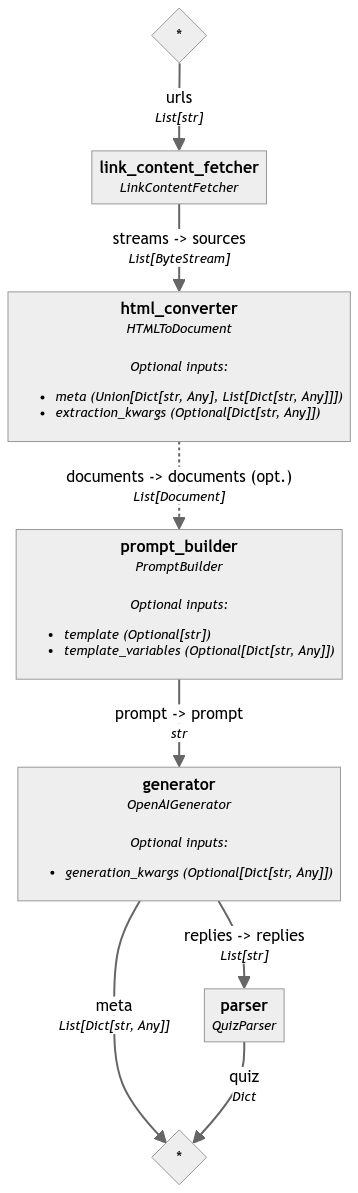

In [40]:
quiz_generation_pipeline.show()

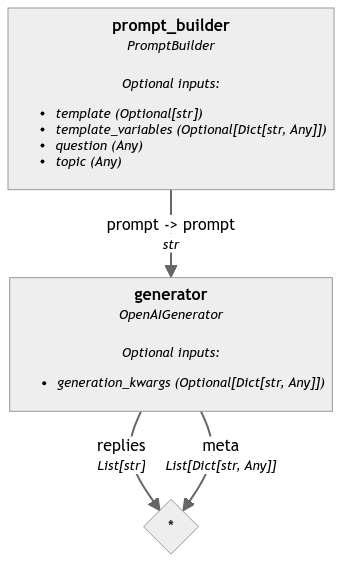

In [41]:
closed_book_answer_pipeline.show()

In [33]:
web_rag_template = """Answer the question about "{{topic}}", using your knowledge and the snippets extracted from the web.

In the answer, just specify the letter corresponding to the option.
If you don't know the answer, just provide your best guess and do not provide any reasoning.

For example, if you think the answer is the first option, just write "a".
If you think the answer is the second option, just write "b", and so on.

question: {{ question["question"] }}
options: {{ question["options"] }}

Snippets:
{% for doc in documents %}
- snippet: "{{doc.content}}"
{% endfor %}

chosen option (a, b, c, or d):
"""

web_rag_pipeline = Pipeline()
web_rag_pipeline.add_component("websearch", SerperDevWebSearch(top_k=3))
web_rag_pipeline.add_component(
    "prompt_builder", PromptBuilder(template=web_rag_template)
)
web_rag_pipeline.add_component(
    "generator",
    OpenAIGenerator(
        api_key=Secret.from_env_var("GROQ_API_KEY"),
        api_base_url="https://api.groq.com/openai/v1",
        model="llama3-8b-8192",
        generation_kwargs={"max_tokens": 5, "temperature": 0, "top_p": 1},
    ),
)
web_rag_pipeline.connect("websearch.documents", "prompt_builder.documents")
web_rag_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - websearch: SerperDevWebSearch
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - websearch.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

In [38]:
web_rag_pipeline.draw('web_rag.png')